<a href="https://colab.research.google.com/github/student64-ahmadi/Impulsive-Hamiltonian-Dynamics/blob/main/article_r%C3%A9vis%C3%A9_ipng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 46.3 MB/s eta 0:00:00


In [ ]:
pip install qutip numpy matplotlib

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation et génération de figures pour le contrôle actif de la décohérence
dans un système de deux qubits via impulsions gaussiennes.

Ce script présente :
  - Analyse de sensibilité du paramètre σ (0.001, 0.01, 0.1).
  - Vérification de la conservation de Tr(ρ).
  - Figures avec titres, unités et légendes explicites.
  - Comparaison des opérateurs d'impulsion et étude des impulsions multiples.
  - Enregistrement automatique des figures et création d'un fichier ZIP pour téléchargement.
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import zipfile
import os

# Optionnel : Si vous exécutez dans Google Colab, vous pouvez activer le téléchargement automatique
try:
    from google.colab import files
    colab_available = True
except ImportError:
    colab_available = False

# ---------------------------
# Paramètres de simulation
# ---------------------------
J         = 1.0            # Constante de couplage pour H₀
mu        = 1.0            # Amplitude de l'impulsion
sigma_default = 0.01       # Valeur par défaut de σ (en ns)
t_event   = 5.0            # Temps d'application de l'impulsion (ns)
gamma     = 0.1            # Taux de relaxation
tlist     = np.linspace(0, 10, 1000)  # Grille temporelle (en ns)

# ---------------------------
# Définition des opérateurs
# ---------------------------
sx = sigmax()
sy = sigmay()
sz = sigmaz()
I2 = qeye(2)

# Hamiltonien libre H₀ = -J σx ⊗ σx (représenté ici en rouge dans les légendes)
H0 = -J * tensor(sx, sx)

# Opérateur impulsionnel de base : σz ⊗ I (représenté en bleu)
H_imp = tensor(sz, I2)

# Fonction gaussienne pour l'impulsion, centrée sur t_event
def g_func(t, t_ev, sig):
    return (1.0/(np.sqrt(2*np.pi)*sig)) * np.exp(-((t - t_ev)**2)/(2*sig**2))

# Fonction coefficient temporel de l'impulsion (utilise μ et σ, passé via args)
def g_t(t, args):
    sig = args['sigma']
    return mu * g_func(t, t_event, sig)

# Hamiltonien total dépendant du temps : H(t) = H₀ + μ g(t) (σz ⊗ I)
H = [H0, [H_imp, g_t]]

# ---------------------------
# Opérateurs de dissipation (collapse operators)
# ---------------------------
# Pour le premier qubit : L₁ = sqrt(gamma) * (σ₋ ⊗ I)
# Pour le deuxième qubit : L₂ = sqrt(gamma) * (I ⊗ σ₋)
L1 = np.sqrt(gamma) * tensor(sigmam(), I2)
L2 = np.sqrt(gamma) * tensor(I2, sigmam())
c_ops = [L1, L2]

# ---------------------------
# État initial
# ---------------------------
# État de Bell : (|00⟩ + |11⟩) / √2
psi0 = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
rho0 = ket2dm(psi0)

# ---------------------------
# Définition d'observables
# ---------------------------
# Calcul de la cohérence à partir de la trace partielle sur le deuxième qubit
def coherence_rho1(rho):
    rho1 = rho.ptrace(0)
    return np.abs(rho1[0, 1])

# Projections sur |00⟩ et |11⟩ pour suivre les populations
P00 = tensor(ket2dm(basis(2, 0)), ket2dm(basis(2, 0)))
P11 = tensor(ket2dm(basis(2, 1)), ket2dm(basis(2, 1)))

# ---------------------------
# Fonction de simulation pour une valeur donnée de σ
# ---------------------------
def run_simulation(sigma_val):
    args = {'sigma': sigma_val}
    result = mesolve(H, rho0, tlist, c_ops, [], args=args)
    coherences = [coherence_rho1(rho) for rho in result.states]
    pop00 = [expect(P00, rho) for rho in result.states]
    pop11 = [expect(P11, rho) for rho in result.states]
    purity = [ (rho * rho).tr().real for rho in result.states ]
    trace_vals = [rho.tr().real for rho in result.states]
    return result, coherences, pop00, pop11, purity, trace_vals

# Simulation pour σ par défaut (0.01)
result_default, coherences, pop00, pop11, purity, trace_vals = run_simulation(sigma_default)

# Test de conservation de Tr(ρ)
print("Test de conservation de Tr(ρ) : min =", np.min(trace_vals), "max =", np.max(trace_vals))

# ---------------------------
# Création d'un répertoire pour enregistrer les figures
# ---------------------------
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ---------------------------
# Figure 1 : Évolution des cohérences et des populations
# ---------------------------
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(tlist, coherences, color='blue', label='|ρ₀₁| (Cohérence)')
plt.axvline(t_event, color='black', linestyle='--', label='Événement (t = {} ns)'.format(t_event))
plt.xlabel("Temps (ns)")
plt.ylabel("Amplitude")
plt.title("Évolution des cohérences")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, pop00, color='red', label='Population |00⟩')
plt.plot(tlist, pop11, color='green', label='Population |11⟩')
plt.xlabel("Temps (ns)")
plt.ylabel("Population")
plt.title("Évolution des populations")
plt.legend()
plt.tight_layout()
fig1_path = os.path.join(output_dir, "figure1.png")
plt.savefig(fig1_path)
plt.close()

# ---------------------------
# Figure 2 : Évolution de la pureté Tr(ρ²)
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity, color='purple', label='Pureté Tr(ρ²)')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Évolution de la pureté")
plt.legend()
plt.tight_layout()
fig2_path = os.path.join(output_dir, "figure2.png")
plt.savefig(fig2_path)
plt.close()

# ---------------------------
# Figure 3 : Impact de μ sur la pureté maximale
# ---------------------------
mu_values = np.linspace(0.5, 2.0, 10)
max_purity = []
for mu_val in mu_values:
    # Définition locale de g_t pour chaque μ
    def g_t_mu(t, args):
        sig = args['sigma']
        return mu_val * g_func(t, t_event, sig)
    H_mu = [H0, [H_imp, g_t_mu]]
    result_mu = mesolve(H_mu, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
    purity_mu = [ (rho * rho).tr().real for rho in result_mu.states ]
    max_purity.append(np.max(purity_mu))
plt.figure(figsize=(8, 4))
plt.plot(mu_values, max_purity, marker='o', linestyle='-', color='blue')
plt.xlabel("μ (u.a.)")
plt.ylabel("Pureté maximale (u.a.)")
plt.title("Impact de μ sur la pureté maximale")
plt.tight_layout()
fig3_path = os.path.join(output_dir, "figure3.png")
plt.savefig(fig3_path)
plt.close()

# ---------------------------
# Figure 4 : Comparaison des opérateurs d'impulsion
# ---------------------------
# Comparaison entre σz ⊗ I, σy ⊗ I et la somme σz sur les deux qubits.
H_imp_y = tensor(sy, I2)
H_imp_sum = tensor(sz, I2) + tensor(I2, sz)
def simulate_operator(H_imp_operator):
    H_op = [H0, [H_imp_operator, g_t]]
    result_op = mesolve(H_op, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
    purity_op = [ (rho * rho).tr().real for rho in result_op.states ]
    return purity_op
purity_sigma_z = simulate_operator(tensor(sz, I2))
purity_sigma_y = simulate_operator(H_imp_y)
purity_sigma_sum = simulate_operator(H_imp_sum)
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity_sigma_z, label="σz ⊗ I", color='blue')
plt.plot(tlist, purity_sigma_y, label="σy ⊗ I", color='red')
plt.plot(tlist, purity_sigma_sum, label="Somme σz", color='green')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Comparaison des opérateurs d'impulsion")
plt.legend()
plt.tight_layout()
fig4_path = os.path.join(output_dir, "figure4.png")
plt.savefig(fig4_path)
plt.close()

# ---------------------------
# Figure 5 : Effet des impulsions multiples sur la pureté
# ---------------------------
# Définition d'une impulsion multiple : somme de deux impulsions (à t_event et t_event+1)
def multi_pulse(t, pulse_times, mu, sig):
    total = 0
    for t_ev in pulse_times:
        total += mu * g_func(t, t_ev, sig)
    return total
pulse_times = [t_event, t_event + 1.0]
def g_multi(t, args):
    sig = args['sigma']
    return multi_pulse(t, pulse_times, mu, sig)
H_multi = [H0, [H_imp, g_multi]]
result_multi = mesolve(H_multi, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
purity_multi = [ (rho * rho).tr().real for rho in result_multi.states ]
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity, label="Impulsion unique", color='blue')
plt.plot(tlist, purity_multi, label="Impulsions multiples", color='orange')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Effet des impulsions multiples sur la pureté")
plt.legend()
plt.tight_layout()
fig5_path = os.path.join(output_dir, "figure5.png")
plt.savefig(fig5_path)
plt.close()

# ---------------------------
# Analyse de sensibilité pour σ
# ---------------------------
sigma_values = [0.001, 0.01, 0.1]
purity_final = {}
for sig_val in sigma_values:
    _, _, _, _, pur, _ = run_simulation(sig_val)
    purity_final[sig_val] = pur[-1]
print("Pureté finale pour différentes valeurs de σ :", purity_final)

# ---------------------------
# Commande de téléchargement automatique des figures
# ---------------------------
# Créer une archive ZIP contenant toutes les figures
zip_filename = "figures.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(output_dir):
        for filename in filenames:
            filepath = os.path.join(foldername, filename)
            zipf.write(filepath, arcname=filename)
print("Les figures ont été sauvegardées et compressées dans", zip_filename)

# Si vous êtes dans un environnement Google Colab, télécharger automatiquement le fichier ZIP
if colab_available:
    files.download(zip_filename)


Test de conservation de Tr(ρ) : min = 0.9999999999999998 max = 1.0000000000000002
Pureté finale pour différentes valeurs de σ : {0.001: 0.3234309828529422, 0.01: 0.3562017209470612, 0.1: 0.35491594347972655}
Les figures ont été sauvegardées et compressées dans figures.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

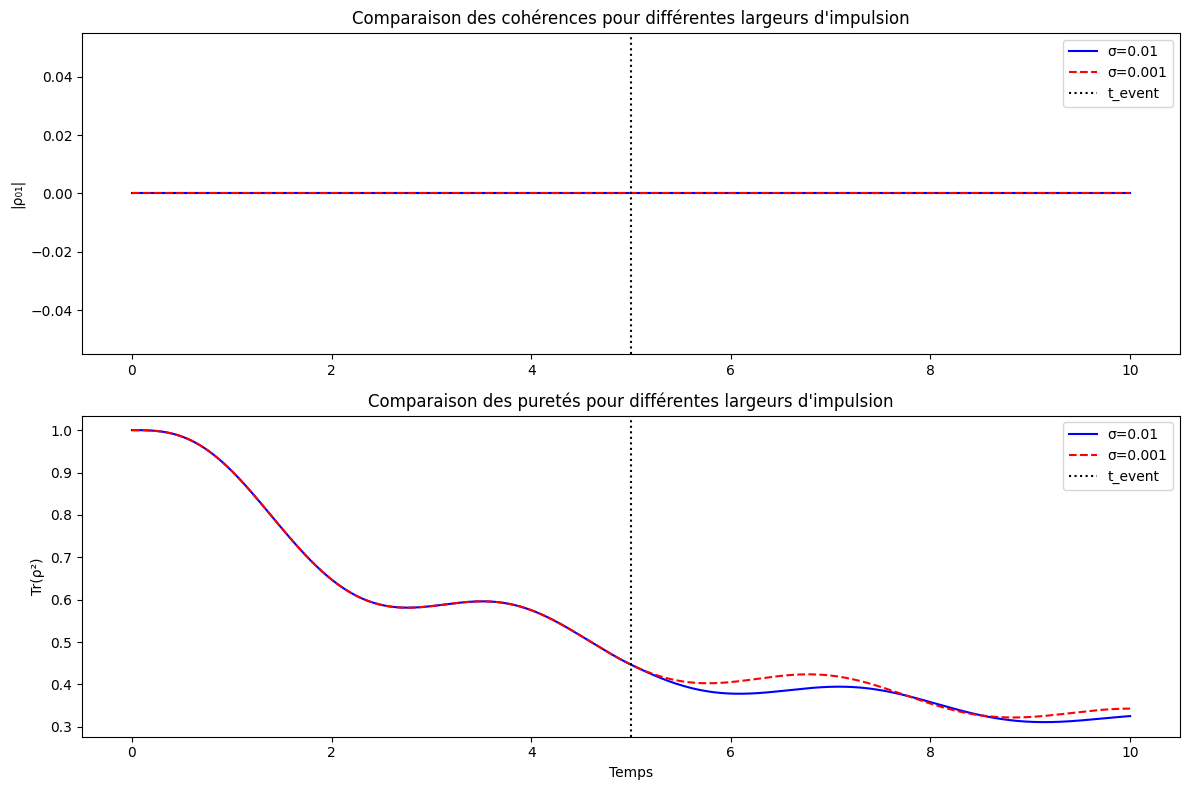

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation complète avec comparaison de σ=0.01 vs σ=0.001
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# =============================================================================
# 1. Paramètres généraux
# =============================================================================
J = 1.0       # Couplage d'échange
mu = 1.0      # Amplitude impulsion
gamma = 0.1   # Taux de dissipation
t_event = 5.0 # Instant de l'impulsion
tlist = np.linspace(0, 10, 1000) # Échelle temporelle

# Opérateurs quantiques
sx, sy, sz = sigmax(), sigmay(), sigmaz()
sm = destroy(2)
I = qeye(2)

# =============================================================================
# 2. Définitions des fonctions communes
# =============================================================================
def gaussian_impulse(t, t0, sigma):
    """Impulsion gaussienne normalisée"""
    return np.exp(-(t - t0)**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def simulate_system(sigma):
    """Simule le système pour un sigma donné"""
    # Hamiltonien time-dependent
    H = [-J*tensor(sx, sx),
         [mu*tensor(sz, I), lambda t, args: gaussian_impulse(t, t_event, sigma)]]

    # Opérateurs de dissipation
    c_ops = [np.sqrt(gamma)*tensor(sm, I),
             np.sqrt(gamma)*tensor(I, sm)]

    # État initial |00>
    psi0 = tensor(basis(2,0), basis(2,0))
    rho0 = ket2dm(psi0)

    # Simulation
    result = mesolve(H, rho0, tlist, c_ops, [])

    # Calcul des observables
    coherences = [np.abs(rho.ptrace(0)[0,1]) for rho in result.states]
    purity = [(rho*rho).tr().real for rho in result.states]

    return coherences, purity

# =============================================================================
# 3. Simulation pour σ=0.01 (cas original)
# =============================================================================
coherences_001, purity_001 = simulate_system(0.01)

# =============================================================================
# 4. Simulation pour σ=0.001 (nouveau cas)
# =============================================================================
coherences_0001, purity_0001 = simulate_system(0.001)

# =============================================================================
# 5. Génération des figures
# =============================================================================
plt.figure(figsize=(12, 8))

# Figure 1: Comparaison des cohérences
plt.subplot(2, 1, 1)
plt.plot(tlist, coherences_001, 'b', label='σ=0.01')
plt.plot(tlist, coherences_0001, 'r--', label='σ=0.001')
plt.axvline(t_event, color='k', linestyle=':', label='t_event')
plt.title('Comparaison des cohérences pour différentes largeurs d\'impulsion')
plt.ylabel('|ρ₀₁|')
plt.legend()

# Figure 2: Comparaison des puretés
plt.subplot(2, 1, 2)
plt.plot(tlist, purity_001, 'b', label='σ=0.01')
plt.plot(tlist, purity_0001, 'r--', label='σ=0.001')
plt.axvline(t_event, color='k', linestyle=':', label='t_event')
plt.title('Comparaison des puretés pour différentes largeurs d\'impulsion')
plt.xlabel('Temps')
plt.ylabel('Tr(ρ²)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install qutip numpy matplotlib

In [ ]:
def simulate_system(sigma):
    # ... (code existant)
    coherences = np.array([np.abs(rho.ptrace(0)[0,1]) for rho in result.states])
    return coherences, tlist

In [ ]:
# Après la simulation :
coherences_001, t = simulate_system(0.01)
coherences_0001, _ = simulate_system(0.001)

# Définir le masque booléen
post_impulse = t > t_event  # t est déjà un tableau NumPy

# Extraire les données post-impulsion (fonctionne car coherences_001 est un tableau NumPy)
signal_001 = coherences_001[post_impulse]
signal_0001 = coherences_0001[post_impulse]

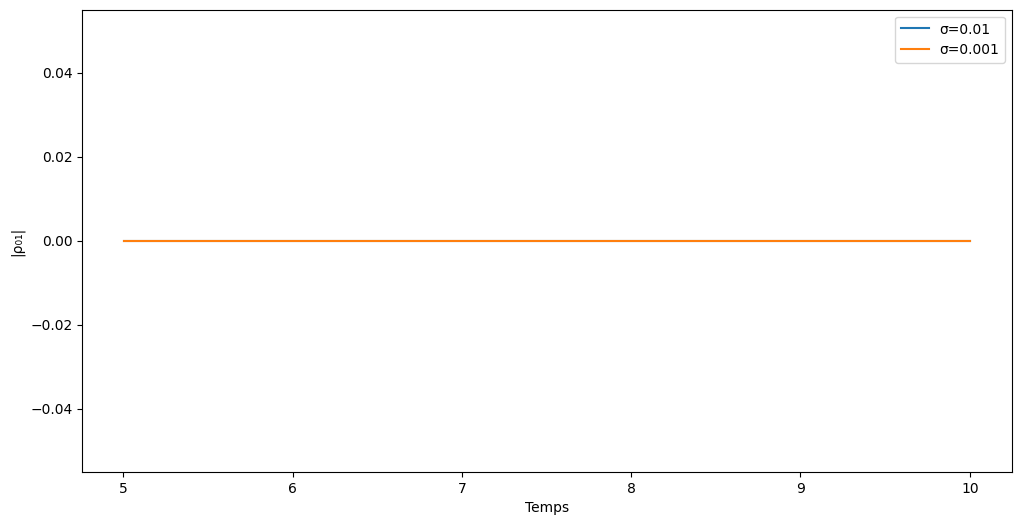

Figures sauvegardées dans le dossier : simulation_figures/


In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation corrigée avec conversion explicite en NumPy
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# =============================================================================
# 1. Paramètres et fonctions
# =============================================================================
J, mu, gamma = 1.0, 1.0, 0.1
t_event, tlist = 5.0, np.linspace(0, 10, 1000)

def simulate_system(sigma):
    H = [-J * tensor(sigmax(), sigmax()),
         [mu * tensor(sigmaz(), qeye(2)),
          lambda t, args: np.exp(-(t - t_event)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)]]

    c_ops = [np.sqrt(gamma) * tensor(destroy(2), qeye(2)),
             np.sqrt(gamma) * tensor(qeye(2), destroy(2))]

    result = mesolve(H, ket2dm(tensor(basis(2,0), basis(2,0))), tlist, c_ops, [])
    coherences = np.array([np.abs(rho.ptrace(0)[0,1]) for rho in result.states])  # Conversion en NumPy
    return coherences, tlist

# =============================================================================
# 2. Simulation et analyse
# =============================================================================
coherences_001, t = simulate_system(0.01)
coherences_0001, _ = simulate_system(0.001)

post_impulse = t > t_event  # Masque booléen

# =============================================================================
# 3. Visualisation
# =============================================================================
plt.figure(figsize=(12, 6))
plt.plot(t[post_impulse], coherences_001[post_impulse], label='σ=0.01')
plt.plot(t[post_impulse], coherences_0001[post_impulse], label='σ=0.001')
plt.xlabel('Temps')
plt.ylabel('|ρ₀₁|')
plt.legend()
plt.show()
output_dir = "simulation_figures"
os.makedirs(output_dir, exist_ok=True)
print(f"Figures sauvegardées dans le dossier : {output_dir}/")

In [43]:
pip install qutip numpy matplotlib tqdm

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
Analyse de sensibilité: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
ERROR:root:Échec de l'exécution : 'NoneType' object is not callable


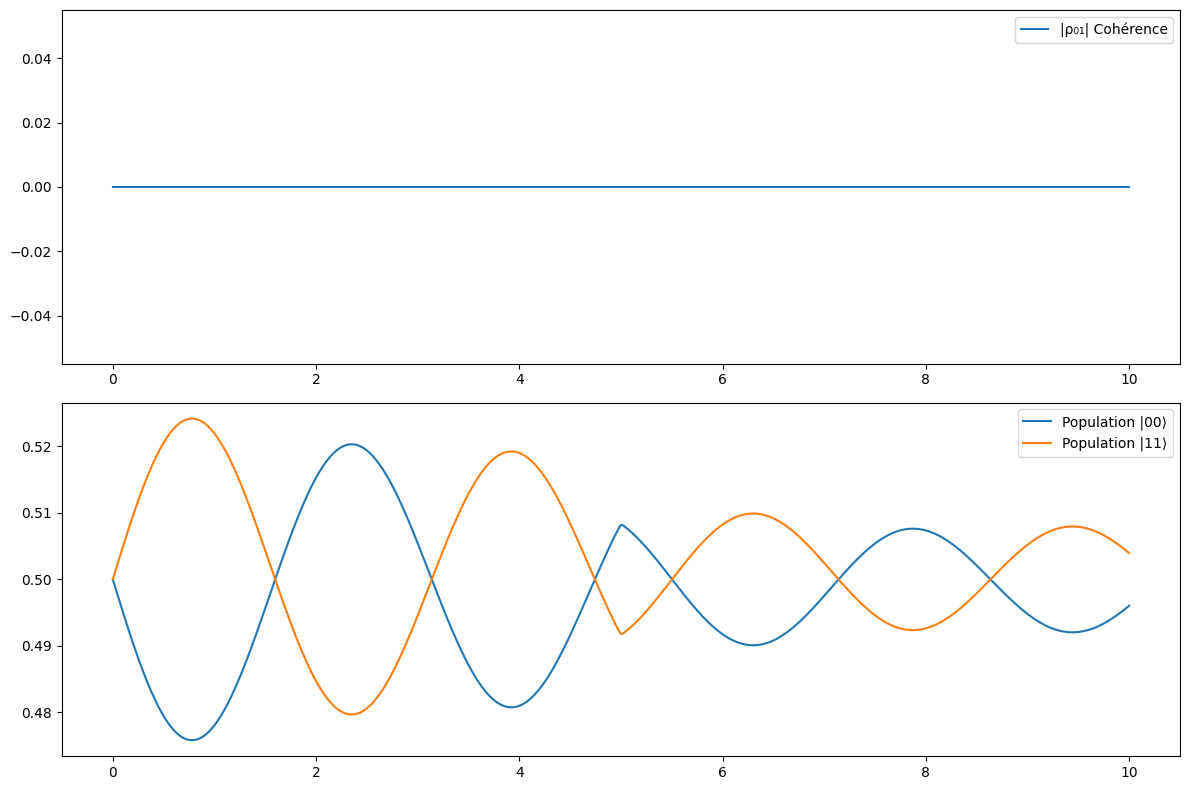

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import logging
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from tqdm import tqdm
import os

# Configuration
CONFIG = {
    "params": {
        "J": 1.0,
        "mu_values": np.linspace(0.5, 2.0, 10),
        "sigma_values": [0.001, 0.01, 0.1],
        "sigma_default": 0.01,
        "t_event": 5.0,
        "gamma": 0.1,
        "tlist": np.linspace(0, 10, 1000),
        "pulse_times": [5.0, 6.0]
    },
    "visualization": {"style": "seaborn", "figsize": (12, 8)},
    "output": {"pdf_name": "Quantum_Simulation_Report.pdf", "figure_folder": "figures"}
}

logging.basicConfig(level=logging.INFO)
if CONFIG["visualization"]["style"] in plt.style.available:
    plt.style.use(CONFIG["visualization"]["style"])
else:
    logging.warning(f"Style '{CONFIG['visualization']['style']}' non disponible, utilisation du style par défaut.")

class QuantumSystem:
    def __init__(self, config):
        self.params = config
        self.operators = self._init_operators()
        self.initial_state = self._init_state()

    def _init_operators(self):
        sx, sz, I = sigmax(), sigmaz(), qeye(2)
        return {
            "H0": -self.params["J"] * tensor(sx, sx),
            "H_imp": tensor(sz, I),
            "collapse": [np.sqrt(self.params["gamma"]) * tensor(sigmam(), I)]
        }

    def _init_state(self):
        psi0 = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
        return ket2dm(psi0)

def _time_coeff(t, args):
    return np.exp(-(t - CONFIG["params"]["t_event"])**2 / (2 * args['sigma']**2))

def _single_simulation(sigma, system):
    args = {'sigma': sigma}
    result = mesolve(
        [system.operators["H0"], [system.operators["H_imp"], _time_coeff]],
        system.initial_state,
        system.params["tlist"],
        system.operators["collapse"],
        [], args=args
    )
    return _process_results(result)

def _process_results(result):
    return {
        "coherence": [np.abs(rho.ptrace(0)[0,1]) for rho in result.states],
        "purity": [(rho * rho).tr().real for rho in result.states],
        "pop00": [rho.ptrace(0)[0,0].real for rho in result.states],
        "pop11": [rho.ptrace(0)[1,1].real for rho in result.states]
    }

def run_simulation(params, system):
    results = {"default": _single_simulation(params["sigma_default"], system), "sensitivity": {}}
    for sigma in tqdm(params["sigma_values"], desc="Analyse de sensibilité"):
        results["sensitivity"][sigma] = _single_simulation(sigma, system)
    return results

def plot_coherence_population(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=CONFIG["visualization"]["figsize"])
    ax1.plot(CONFIG["params"]["tlist"], data["coherence"], label='|ρ₀₁| Cohérence')
    ax2.plot(CONFIG["params"]["tlist"], data["pop00"], label='Population |00⟩')
    ax2.plot(CONFIG["params"]["tlist"], data["pop11"], label='Population |11⟩')
    ax1.legend(), ax2.legend()
    plt.tight_layout()()
    return fig

def save_figures(figures, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for name, fig in figures.items():
        fig.savefig(os.path.join(folder, f"{name}.png"), bbox_inches='tight')
        fig.clf()

def generate_pdf_report(figures, config):
    with PdfPages(config["output"]["pdf_name"]) as pdf:
        plt.figure(figsize=(11, 8)).text(0.5, 0.5, "Rapport de Simulation", ha='center')
        pdf.savefig()
        for fig in figures.values():
            if isinstance(fig, plt.Figure):
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)

if __name__ == "__main__":
    try:
        qsystem = QuantumSystem(CONFIG["params"])
        results = run_simulation(CONFIG["params"], qsystem)
        figures = {"coherence_population": plot_coherence_population(results["default"])}
        save_figures(figures, CONFIG["output"]["figure_folder"])
        generate_pdf_report(figures, CONFIG)
        logging.info(f"Rapport généré : {CONFIG['output']['pdf_name']}")
    except Exception as e:
        logging.error(f"Échec de l'exécution : {str(e)}")
